In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn import ensemble, linear_model, metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import pre-processed grinder data
grind_df = pd.read_csv(r'.\Grinder Pre-Processed.csv')
grind_df.head(5)

,Brand,Source,Size,Price,Cordless,Auto
0,Stanley,Lazada,7.0,1224900,0,0
1,Dewalt,Lazada,7.0,1988000,0,0
2,Dewalt,Lazada,7.0,1550000,0,0
3,Maktec,Lazada,7.0,1950000,0,0
4,Tekiro Ryu,Lazada,7.0,1131800,0,0


(array([2.630e+02, 1.091e+03, 1.546e+03, 9.140e+02, 6.390e+02, 4.520e+02,
        3.920e+02, 2.270e+02, 1.090e+02, 8.300e+01, 7.600e+01, 1.660e+02,
        1.280e+02, 1.060e+02, 9.600e+01, 7.400e+01, 6.100e+01, 6.700e+01,
        2.000e+01, 1.600e+01, 9.000e+00, 5.000e+00, 6.000e+00, 5.000e+00,
        1.000e+00, 6.000e+00, 1.000e+01, 7.000e+00, 2.000e+00, 1.000e+00,
        6.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

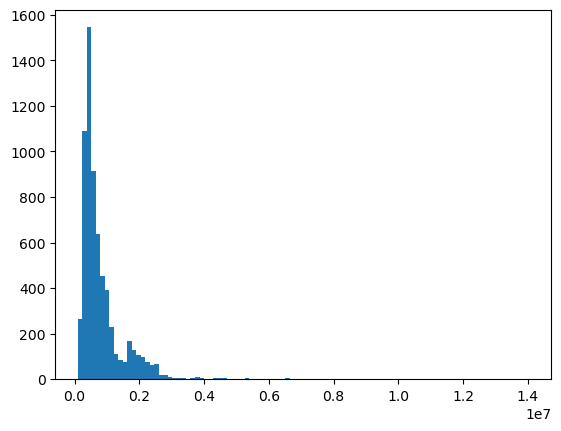

In [3]:
# Plot hitogram of price
plt.hist(grind_df['Price'],bins=100)

In [4]:
grind_df = grind_df[grind_df['Price']<1e7] # we filter the price above 10M IDR, because most likely the product is unit of grinder (consist multiple size)

## ML Process

In [6]:
# Split between features and target
x = grind_df[['Brand','Source','Size','Cordless','Auto']]
y = grind_df[['Price']]

### Encoding

In [8]:
# Encode categorical column using target encoding algorithm
target_encoder = TargetEncoder(cols=['Brand','Source'])
x_encoded = target_encoder.fit_transform(x,y)

### Search for base model

In this step we will search the best regressor model for this project. We will try 3 models and we will use kfold cross validation to minimize the oversampling

In [10]:
# We use k-fold algorithm to avoid oversampling
kf = KFold(n_splits=5, shuffle=True, random_state=1) # initialize kfold algorithm

In [11]:
# We will try many type of model to compare and get best model so we will initialize array consist of models
models = [ensemble.GradientBoostingRegressor(),ensemble.RandomForestRegressor(),linear_model.LinearRegression()]
models_name = ['Gradient Boost','Random Forest','Linear']

In [12]:
# Loop for each model
for i,model in enumerate(models):
    rmse_scores = [] # empty array to store mse for each fold
    r2_scores =[] # empty array to store r2 for each fold

    for train_idx, test_idx in kf.split(x):
        x_train, x_test = x_encoded.iloc[train_idx], x_encoded.iloc[test_idx] # get data for feature for train and test
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # get data for target for train and test

        # Train the model
        model.fit(x_train,y_train)

        # Testing the model
        y_pred = model.predict(x_test)

        # Calculate and store both mse and r2
        rmse = metrics.root_mean_squared_error(y_test,y_pred)
        rmse_scores.append(rmse)
        r2 = metrics.r2_score(y_test,y_pred)
        r2_scores.append(r2)
    
    avg_rmse = sum(rmse_scores) / len(rmse_scores)
    avg_r2 = sum(r2_scores) / len(r2_scores)
    print(f'{models_name[i]}\nAverage Root Mean Squared Error: {avg_rmse:.0f}\nAverage R2: {avg_r2:.2f}\n')
        

Gradient Boost
Average Root Mean Squared Error: 300625
Average R2: 0.82

Random Forest
Average Root Mean Squared Error: 306621
Average R2: 0.81

Linear
Average Root Mean Squared Error: 431054
Average R2: 0.63



based on the result we can see that Gradient Boost model performance is the best, we will use Gradient bost as our model

### Hyper-parameter tunning

We will use grid search for the hyper-parameter tunning

In [15]:
# define the grid of parameter we will try
param_grid = {
    'n_estimators': [100, 200, 300,400,500],
    'learning_rate': [0.1,0.5,1,5]
}

In [16]:
# define the model
grd = ensemble.GradientBoostingRegressor()

In [17]:
grid_search = model_selection.GridSearchCV(grd,param_grid=param_grid,cv=5,scoring='neg_root_mean_squared_error')

In [20]:
grid_search.fit(x_encoded,y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.5, 1, 5],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_root_mean_squared_error')

In [21]:
# Get the best parameter
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [24]:
# Use the best parameter for our final model
rmse_scores = [] # empty array to store mse for each fold
r2_scores =[] # empty array to store r2 for each fold
fin_model = ensemble.GradientBoostingRegressor(learning_rate=0.1,n_estimators=100,random_state=1)
for train_idx, test_idx in kf.split(x):
        x_train, x_test = x_encoded.iloc[train_idx], x_encoded.iloc[test_idx] # get data for feature for train and test
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # get data for target for train and test

        # Train the model
        fin_model.fit(x_train,y_train)

        # Testing the model
        y_pred = fin_model.predict(x_test)

        # Calculate and store both mse and r2
        rmse = metrics.root_mean_squared_error(y_test,y_pred)
        rmse_scores.append(rmse)
        r2 = metrics.r2_score(y_test,y_pred)
        r2_scores.append(r2)
    
avg_rmse = sum(rmse_scores) / len(rmse_scores)
avg_r2 = sum(r2_scores) / len(r2_scores)
print(f'Average Root Mean Squared Error: {avg_rmse:.0f}\nAverage R2: {avg_r2:.2f}')

Average Root Mean Squared Error: 300625
Average R2: 0.82


The result of hyper parameter tuning gave us same parameter as base model

## Conclusion

We have tried to create grinder machine price estimator for e-commerce data. As a result we have gradient model with performance R2 about 0.82 and RMSE about 300K. Personally i think the result of R2 is good enough, but the RMSE perfomance is not quite good enough as the number is still quite high. 

I think there are several factors that can affect the result, especially because this is e-commerce data. Factors like discount, event (certain event can make the price lower or higher), platform cost, etc can change the price significantly in span of short time.

We can also get better result if we can get better detail product. Up until now, we solely rely on product name to get the specification of the product, there is high probability that seller didn't put detail specifications on the product name. So if we can get more detail of specification, we can get better understanding of the product.